In [34]:
TRAIN = 0
REBUILD_DATA = 0
AD_TEST_ONLY = 1
KINECT = 0

TRAIN_CSV = 'train_combined_poses.csv'
TEST_CSV = 'test_combined_poses.csv'
AD_TEST_CSV = 'test_additional.csv'

MODEL_ARCH_FILE = 'model_5l_combined_poses_8classes.json'
# MODEL_WEIGHTS = 'model_5l_weight_ep50_combined_poses_8classes.hdf5'
MODEL_WEIGHTS = 'checkpoints/hand_segnet_model.00097-0.0249-0.9907-0.0289-0.9896.hdf5'
TRAINING_HIST = 'training_his_combined_poses_8classes.pickle'

train_data_path = 'train_data_abcde_combined_poses_8classes.npy'
train_label_path = 'train_label_abcde_combined_poses_8classes.npy'
test_data_path = 'test_data_abcde_combined_poses_8classes.npy'
test_label_path = 'test_label_abcde_combined_poses_8classes.npy'
ad_test_data_path = 'test_data_additional_8classes.npy'
ad_test_label_path = 'test_label_additional_8classes.npy'

path = ''
# img_w = 512
# img_w = 424
img_w = 128
img_h = 128
# img_w = 378
# img_h = 161

n_labels = 8

kernel = 3

n_train = 24500
n_test = 10500
n_ad_test = 21500

#     n_train = 2
#     n_test = 2

# SegNet model implemented with keras

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from skimage.transform import resize
from skimage import color

from matplotlib import pyplot as plt

import os

from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.optimizers import SGD, Adam
from tensorflow.contrib.keras.python.keras.models import model_from_json
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build model
from tensorflow.contrib.keras.python.keras.layers.core import Activation, Reshape, Permute, Flatten, Dense
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers import Dropout
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

import json

import pickle

from IPython.display import clear_output

import time

import cv2

# Kinect

In [3]:
from pykinect2 import PyKinectV2
from pykinect2.PyKinectV2 import *
from pykinect2 import PyKinectRuntime

import ctypes
import _ctypes
import pygame

if sys.hexversion >= 0x03000000:
    import _thread as thread
else:
    import thread
    
# colors for drawing different bodies 
SKELETON_COLORS = [pygame.color.THECOLORS["red"],
                    pygame.color.THECOLORS["blue"], 
                    pygame.color.THECOLORS["green"],
                    pygame.color.THECOLORS["orange"], 
                    pygame.color.THECOLORS["purple"], 
                    pygame.color.THECOLORS["yellow"], 
                    pygame.color.THECOLORS["violet"]]

### Utility functions

In [4]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(np.ceil(labels[r][c]))] = 1
    return np.uint8(label_map)
#     print(np.unique(label_map))
#     return label_map

In [5]:
def label_map_8_classes(gt2):
    label_map = np.zeros([img_h, img_w, n_labels])
    
#     print(np.unique(gt2))
    for color_chal in [0, 1, 2]:
        x = gt2[:, :, color_chal]
        x[x == 0] = 1
        x[x == 127] = 2
        x[x == 255] = 3
        gt2[:, :, color_chal] = x
        
    gt3 = gt2[:, :, 0] + 10*gt2[:, :, 1] + 100*gt2[:, :, 2]
#     print(np.unique(gt3))
    
#     gt3[gt3 == 77] = 0
    gt3[gt3 == 111] = 0
    gt3[gt3 == 112] = 1
    gt3[gt3 == 121] = 2
    gt3[gt3 == 211] = 3
    gt3[gt3 == 212] = 4
    gt3[gt3 == 221] = 5
    gt3[gt3 == 222] = 6
    gt3[gt3 == 333] = 7
    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, int(gt3[r][c])] = 1
    
#     111.  112.  121.  211.  212.  221.  222.  333
    
#     print(np.unique(gt3))

    return np.uint8(label_map)
        
#     plt.imshow(gt3, cmap='gray')
#     plt.show()    
    
#     np.savetxt('asd.txt', gt3, fmt='%d')

In [6]:
def prep_data(mode):
#     n_train = 2
#     n_test = 2
    assert mode in {'test', 'train', 'ad_test'}, \
        'mode should be either \'test\' or \'train\' or \'ad_test\''
    data = []
    label = []
    if mode == 'train':
        df = pd.read_csv(path + TRAIN_CSV)
        n = n_train
    elif mode == 'test':
        df = pd.read_csv(path + TEST_CSV)
        n = n_test
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
        n = n_ad_test
        
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(imread(path + item[1]), (img_h, img_w), preserve_range=True, order=0)
        
        data.append(img)
        label.append(label_map_8_classes(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
#     print(np.unique(data))
#     print(np.unique(label))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label


# def prep_data(mode):
# #     n_train = 2
# #     n_test = 2
#     assert mode in {'test', 'train', 'ad_test'}, \
#         'mode should be either \'test\' or \'train\' or \'ad_test\''
#     data = []
#     label = []
#     if mode == 'train':
#         df = pd.read_csv(path + TRAIN_CSV)
#         n = n_train
#     elif mode == 'test':
#         df = pd.read_csv(path + TEST_CSV)
#         n = n_test
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)
#         n = n_ad_test
        
#     for i, item in df.iterrows():
#         if i >= n:
#             break
#         img, gt = [resize(imread(path + item[0]), (img_h, img_w))], resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
        
#         data.append(img)
#         label.append(label_map(gt))
#         sys.stdout.write('\r')
#         sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
#                                                     int(100. * (i + 1) / n)))
#         sys.stdout.flush()
#     sys.stdout.write('\r')
#     sys.stdout.flush()
#     data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))
# #     print(np.unique(data))
# #     print(np.unique(label))

#     print(mode + ': OK')
#     print('\tshapes: {}, {}'.format(data.shape, label.shape))
#     print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
#     print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

#     return data, label

In [7]:
def get_rgb_from_class(pred_cls):
    if pred_cls == 0:
        return [0, 0, 0]
    elif pred_cls == 1:
        return [0, 0, 127]
    elif pred_cls == 2:
        return [0, 127, 0]
    elif pred_cls == 3:
        return [127, 0, 0]
    elif pred_cls == 4:
        return [127, 0, 127]
    elif pred_cls == 5:
        return [127, 127, 0]
    elif pred_cls == 6:
        return [127, 127, 127]
    elif pred_cls == 7:
        return [255, 255, 255]
    
def plot_results_2(output, indx):
    if AD_TEST_ONLY == 0:
        df = pd.read_csv(path + TEST_CSV)
    else:
        df = pd.read_csv(path + AD_TEST_CSV)
    
    n_test_imgs = indx.shape[0]
    plt.figure(figsize=(7, 2 * n_test_imgs))
    
    subplot_indx = 0
    for cur_indx in indx:
        for i, item in df.iterrows():
            if i == cur_indx:
                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 1)
                plt.title('Input Image')
                plt.axis('off')
                im = resize(imread(path + item[0]), (img_h, img_w))
                plt.imshow(im, cmap='gray')

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 2)
                plt.title('Ground Truth')
                plt.axis('off')
                gt = resize(imread(path + item[1]), (img_h, img_w))
                plt.imshow(gt)

                plt.subplot(n_test_imgs, 3, 3 * subplot_indx + 3)
                plt.title('Prediction')
                plt.axis('off')
                
                labeled = np.ones([img_h, img_w, 3]) * 255
                output = np.reshape(output, (5, 128, 128))
                
                for r in range(img_h):
                    for c in range(img_w):
                        re, gr, bl = get_rgb_from_class(output[subplot_indx, r, c])
                        labeled[r, c, 2] = re
                        labeled[r, c, 1] = gr
                        labeled[r, c, 0] = bl
                
                labeled = np.uint8(labeled)
                plt.imshow(labeled)

                subplot_indx += 1

                break

#     plt.savefig('result.png')
    plt.show()

In [8]:
# def plot_results_2(output, indx):
#     if AD_TEST_ONLY == 0:
#         df = pd.read_csv(path + TEST_CSV)
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)
    
#     n_test_imgs = indx.shape[0]
#     plt.figure(figsize=(15, 2 * n_test_imgs))
    
#     subplot_indx = 0
#     for cur_indx in indx:
#         for i, item in df.iterrows():
#             if i == cur_indx:
#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 1)
#                 plt.title('Input Image')
#                 plt.axis('off')
#                 im = resize(imread(path + item[0]), (img_h, img_w))
#                 plt.imshow(im, cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 2)
#                 plt.title('Ground Truth')
#                 plt.axis('off')
#                 gt = resize(np.clip(~(imread(path + item[1])[:, :, 0]), 0, 1), (img_h, img_w))
#                 plt.imshow(np.clip(gt, 0, 1), cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 3)
#                 plt.title('Prediction')
#                 plt.axis('off')
#                 labeled = np.argmax(output[subplot_indx], axis=-1)
#                 plt.imshow(labeled, cmap='gray')

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 4)
#                 plt.title('Heat map')
#                 plt.axis('off')
#                 plt.imshow(output[subplot_indx][:, :, 1])

#                 plt.subplot(n_test_imgs, 5, 5 * subplot_indx + 5)
#                 plt.title('Comparison')
#                 plt.axis('off')
#                 rgb = np.empty((img_h, img_w, 3))
#                 rgb[:, :, 0] = labeled
#                 img = resize(imread(path + item[0]), (img_h, img_w))
#                 rgb[:, :, 1] = img
#                 rgb[:, :, 2] = gt
#                 plt.imshow(rgb)

#                 subplot_indx += 1

#                 break

# #     plt.savefig('result.png')
#     plt.show()

### Build Model

In [9]:
# if os.path.isfile(MODEL_ARCH_FILE):
#     print('Loading model...', end='')
#     with open(MODEL_ARCH_FILE, 'r') as f:
#         json_string = f.read()
#     autoencoder = model_from_json(json_string)
#     print('done.')
# else:
print('Defining model...', end='')
encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('softmax'))

with open(MODEL_ARCH_FILE, 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

print('done.')

print('Compiling model...', end='')
# optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
optimizer = Adam(lr=0.001, decay=0.0005)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print('done.')

print(autoencoder.summary())

Defining model...done.
Compiling model...done.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 

### Data

In [10]:
if 'train_data' in globals():
    del train_data
if 'train_label' in globals():
    del train_label
if 'test_data' in globals():
    del test_data
if 'test_label' in globals():
    del test_label

if 'data' in locals():
    del data
if 'label' in locals():
    del label

In [35]:
n_train = 24500
n_test = 10500
n_ad_test = 21500

# n_train = 2
# n_test = 2

if AD_TEST_ONLY == 0:
    if KINECT == 0:
        if os.path.isfile(train_data_path) and os.path.isfile(train_label_path) and REBUILD_DATA == 0:
            print('Loading training data...', end='')
            train_data = np.load(train_data_path)
            train_label = np.load(train_label_path)
            print('done.')
        else:
            train_data, train_label = prep_data('train')
            np.save(train_data_path, train_data)
            np.save(train_label_path, train_label)

    if os.path.isfile(test_data_path) and os.path.isfile(test_label_path) and REBUILD_DATA == 0:
        print('Loading testing data...', end='')
        test_data = np.load(test_data_path)
        test_label = np.load(test_label_path)
        print('done.')
    else:
        test_data, test_label = prep_data('test')
        np.save(test_data_path, test_data)
        np.save(test_label_path, test_label)
else:
    if os.path.isfile(ad_test_data_path) and os.path.isfile(ad_test_label_path):
        print('Loading additional testing data...', end='')
        test_data = np.load(ad_test_data_path)
        test_label = np.load(ad_test_label_path)
        print('done.')
    else:
        test_data, test_label = prep_data('ad_test')
        np.save(ad_test_data_path, test_data)
        np.save(ad_test_label_path, test_label)

Loading additional testing data...done.


In [12]:
# for c_indx in [0, 1, 2, 3, 4, 5, 6, 7]:
#     print(np.unique(train_label[:, :, c_indx]))
#     print(np.unique(train_label[:, :, c_indx]))

### Train model or load existing weights

In [13]:
if TRAIN == 1 and AD_TEST_ONLY == 0 and KINECT == 0:
    start_time = time.time()
    
    nb_epoch = 100
    batch_size = 8

    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=5)
    checkpointer = ModelCheckpoint(monitor='val_acc', filepath='checkpoints/hand_segnet_model.{epoch:05d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5', verbose=1, save_best_only=True)

    history = autoencoder.fit(train_data, train_label,
                              batch_size=batch_size, epochs=nb_epoch,
                              verbose=1,
                              validation_data=(test_data, test_label),
                              callbacks=[checkpointer])
    
    training_time = time.time() - start_time
    print('> Training time on GTX1080: ' + str(training_time) + ' sec')

    # Save trained model
    autoencoder.save_weights(MODEL_WEIGHTS)
    
    # Save training history
    with open(TRAINING_HIST, 'wb') as f:
        pickle.dump(history.history, f)
        
    history_ = history.history
else:
    print('Loading trained weights...', end='')
    # Load trained model
    autoencoder.load_weights(MODEL_WEIGHTS)
    
    # Load training history
    file = open(TRAINING_HIST, 'rb')
    history_ = pickle.load(file)
    print('done.')

Loading trained weights...done.


In [14]:
# Train on 24500 samples, validate on 10500 samples
# Epoch 1/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.2475 - acc: 0.9356Epoch 00000: val_acc improved from -inf to 0.95102, saving model to checkpoints/hand_segnet_model.00000-0.2474-0.9356-0.1522-0.9510.hdf5
# 24500/24500 [==============================] - 779s - loss: 0.2474 - acc: 0.9356 - val_loss: 0.1522 - val_acc: 0.9510
# Epoch 2/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.1262 - acc: 0.9572Epoch 00001: val_acc improved from 0.95102 to 0.96192, saving model to checkpoints/hand_segnet_model.00001-0.1262-0.9572-0.1077-0.9619.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.1262 - acc: 0.9572 - val_loss: 0.1077 - val_acc: 0.9619
# Epoch 3/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0973 - acc: 0.9649Epoch 00002: val_acc improved from 0.96192 to 0.96810, saving model to checkpoints/hand_segnet_model.00002-0.0973-0.9649-0.0869-0.9681.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0973 - acc: 0.9649 - val_loss: 0.0869 - val_acc: 0.9681
# Epoch 4/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0817 - acc: 0.9698Epoch 00003: val_acc improved from 0.96810 to 0.97184, saving model to checkpoints/hand_segnet_model.00003-0.0817-0.9698-0.0755-0.9718.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0817 - acc: 0.9698 - val_loss: 0.0755 - val_acc: 0.9718
# Epoch 5/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0719 - acc: 0.9731Epoch 00004: val_acc improved from 0.97184 to 0.97470, saving model to checkpoints/hand_segnet_model.00004-0.0719-0.9731-0.0676-0.9747.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0719 - acc: 0.9731 - val_loss: 0.0676 - val_acc: 0.9747
# Epoch 6/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0653 - acc: 0.9754Epoch 00005: val_acc improved from 0.97470 to 0.97666, saving model to checkpoints/hand_segnet_model.00005-0.0653-0.9754-0.0620-0.9767.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0653 - acc: 0.9754 - val_loss: 0.0620 - val_acc: 0.9767
# Epoch 7/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0601 - acc: 0.9773Epoch 00006: val_acc improved from 0.97666 to 0.97874, saving model to checkpoints/hand_segnet_model.00006-0.0601-0.9773-0.0570-0.9787.hdf5
# 24500/24500 [==============================] - 757s - loss: 0.0601 - acc: 0.9773 - val_loss: 0.0570 - val_acc: 0.9787
# Epoch 8/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0565 - acc: 0.9786Epoch 00007: val_acc improved from 0.97874 to 0.97985, saving model to checkpoints/hand_segnet_model.00007-0.0565-0.9786-0.0536-0.9799.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0565 - acc: 0.9786 - val_loss: 0.0536 - val_acc: 0.9799
# Epoch 9/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9798Epoch 00008: val_acc improved from 0.97985 to 0.98056, saving model to checkpoints/hand_segnet_model.00008-0.0533-0.9798-0.0520-0.9806.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0533 - acc: 0.9798 - val_loss: 0.0520 - val_acc: 0.9806
# Epoch 10/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9808Epoch 00009: val_acc improved from 0.98056 to 0.98115, saving model to checkpoints/hand_segnet_model.00009-0.0508-0.9808-0.0502-0.9812.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0508 - acc: 0.9808 - val_loss: 0.0502 - val_acc: 0.9812
# Epoch 11/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9816Epoch 00010: val_acc improved from 0.98115 to 0.98200, saving model to checkpoints/hand_segnet_model.00010-0.0487-0.9816-0.0479-0.9820.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0487 - acc: 0.9816 - val_loss: 0.0479 - val_acc: 0.9820
# Epoch 12/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9823Epoch 00011: val_acc improved from 0.98200 to 0.98282, saving model to checkpoints/hand_segnet_model.00011-0.0469-0.9823-0.0458-0.9828.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0469 - acc: 0.9823 - val_loss: 0.0458 - val_acc: 0.9828
# Epoch 13/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9829Epoch 00012: val_acc improved from 0.98282 to 0.98338, saving model to checkpoints/hand_segnet_model.00012-0.0453-0.9829-0.0445-0.9834.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0453 - acc: 0.9829 - val_loss: 0.0445 - val_acc: 0.9834
# Epoch 14/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9834Epoch 00013: val_acc improved from 0.98338 to 0.98369, saving model to checkpoints/hand_segnet_model.00013-0.0440-0.9834-0.0437-0.9837.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0440 - acc: 0.9834 - val_loss: 0.0437 - val_acc: 0.9837
# Epoch 15/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0428 - acc: 0.9838Epoch 00014: val_acc improved from 0.98369 to 0.98414, saving model to checkpoints/hand_segnet_model.00014-0.0428-0.9838-0.0425-0.9841.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0428 - acc: 0.9838 - val_loss: 0.0425 - val_acc: 0.9841
# Epoch 16/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9842Epoch 00015: val_acc improved from 0.98414 to 0.98429, saving model to checkpoints/hand_segnet_model.00015-0.0417-0.9842-0.0421-0.9843.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0417 - acc: 0.9842 - val_loss: 0.0421 - val_acc: 0.9843
# Epoch 17/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9846Epoch 00016: val_acc improved from 0.98429 to 0.98454, saving model to checkpoints/hand_segnet_model.00016-0.0407-0.9846-0.0414-0.9845.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0407 - acc: 0.9846 - val_loss: 0.0414 - val_acc: 0.9845
# Epoch 18/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9850Epoch 00017: val_acc improved from 0.98454 to 0.98494, saving model to checkpoints/hand_segnet_model.00017-0.0399-0.9850-0.0404-0.9849.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0399 - acc: 0.9850 - val_loss: 0.0404 - val_acc: 0.9849
# Epoch 19/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9853Epoch 00018: val_acc improved from 0.98494 to 0.98530, saving model to checkpoints/hand_segnet_model.00018-0.0391-0.9853-0.0395-0.9853.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0391 - acc: 0.9853 - val_loss: 0.0395 - val_acc: 0.9853
# Epoch 20/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0384 - acc: 0.9855Epoch 00019: val_acc improved from 0.98530 to 0.98564, saving model to checkpoints/hand_segnet_model.00019-0.0384-0.9855-0.0387-0.9856.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0384 - acc: 0.9855 - val_loss: 0.0387 - val_acc: 0.9856
# Epoch 21/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9858Epoch 00020: val_acc improved from 0.98564 to 0.98568, saving model to checkpoints/hand_segnet_model.00020-0.0377-0.9858-0.0385-0.9857.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0377 - acc: 0.9858 - val_loss: 0.0385 - val_acc: 0.9857
# Epoch 22/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9860Epoch 00021: val_acc improved from 0.98568 to 0.98586, saving model to checkpoints/hand_segnet_model.00021-0.0371-0.9860-0.0380-0.9859.hdf5
# 24500/24500 [==============================] - 753s - loss: 0.0371 - acc: 0.9860 - val_loss: 0.0380 - val_acc: 0.9859
# Epoch 23/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9862Epoch 00022: val_acc improved from 0.98586 to 0.98621, saving model to checkpoints/hand_segnet_model.00022-0.0366-0.9862-0.0372-0.9862.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0366 - acc: 0.9862 - val_loss: 0.0372 - val_acc: 0.9862
# Epoch 24/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9864Epoch 00023: val_acc improved from 0.98621 to 0.98632, saving model to checkpoints/hand_segnet_model.00023-0.0361-0.9864-0.0369-0.9863.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0361 - acc: 0.9864 - val_loss: 0.0369 - val_acc: 0.9863
# Epoch 25/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9866Epoch 00024: val_acc improved from 0.98632 to 0.98637, saving model to checkpoints/hand_segnet_model.00024-0.0356-0.9866-0.0367-0.9864.hdf5
# 24500/24500 [==============================] - 750s - loss: 0.0356 - acc: 0.9866 - val_loss: 0.0367 - val_acc: 0.9864
# Epoch 26/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9868Epoch 00025: val_acc improved from 0.98637 to 0.98666, saving model to checkpoints/hand_segnet_model.00025-0.0351-0.9868-0.0361-0.9867.hdf5
# 24500/24500 [==============================] - 750s - loss: 0.0351 - acc: 0.9868 - val_loss: 0.0361 - val_acc: 0.9867
# Epoch 27/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0347 - acc: 0.9870Epoch 00026: val_acc did not improve
# 24500/24500 [==============================] - 750s - loss: 0.0347 - acc: 0.9870 - val_loss: 0.0366 - val_acc: 0.9864
# Epoch 28/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9871Epoch 00027: val_acc improved from 0.98666 to 0.98674, saving model to checkpoints/hand_segnet_model.00027-0.0343-0.9871-0.0358-0.9867.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0343 - acc: 0.9871 - val_loss: 0.0358 - val_acc: 0.9867
# Epoch 29/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9873Epoch 00028: val_acc improved from 0.98674 to 0.98686, saving model to checkpoints/hand_segnet_model.00028-0.0339-0.9873-0.0355-0.9869.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0339 - acc: 0.9873 - val_loss: 0.0355 - val_acc: 0.9869
# Epoch 30/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9874Epoch 00029: val_acc improved from 0.98686 to 0.98695, saving model to checkpoints/hand_segnet_model.00029-0.0336-0.9874-0.0353-0.9869.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0336 - acc: 0.9874 - val_loss: 0.0353 - val_acc: 0.9869
# Epoch 31/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9875Epoch 00030: val_acc improved from 0.98695 to 0.98726, saving model to checkpoints/hand_segnet_model.00030-0.0332-0.9875-0.0346-0.9873.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0332 - acc: 0.9875 - val_loss: 0.0346 - val_acc: 0.9873
# Epoch 32/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9876Epoch 00031: val_acc improved from 0.98726 to 0.98742, saving model to checkpoints/hand_segnet_model.00031-0.0329-0.9876-0.0342-0.9874.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0329 - acc: 0.9876 - val_loss: 0.0342 - val_acc: 0.9874
# Epoch 33/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9878Epoch 00032: val_acc did not improve
# 24500/24500 [==============================] - 751s - loss: 0.0326 - acc: 0.9878 - val_loss: 0.0342 - val_acc: 0.9874
# Epoch 34/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9879Epoch 00033: val_acc improved from 0.98742 to 0.98749, saving model to checkpoints/hand_segnet_model.00033-0.0323-0.9879-0.0340-0.9875.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0323 - acc: 0.9879 - val_loss: 0.0340 - val_acc: 0.9875
# Epoch 35/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0321 - acc: 0.9880Epoch 00034: val_acc did not improve
# 24500/24500 [==============================] - 751s - loss: 0.0321 - acc: 0.9880 - val_loss: 0.0340 - val_acc: 0.9875
# Epoch 36/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9881Epoch 00035: val_acc improved from 0.98749 to 0.98768, saving model to checkpoints/hand_segnet_model.00035-0.0318-0.9881-0.0336-0.9877.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0318 - acc: 0.9881 - val_loss: 0.0336 - val_acc: 0.9877
# Epoch 37/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9882Epoch 00036: val_acc improved from 0.98768 to 0.98772, saving model to checkpoints/hand_segnet_model.00036-0.0316-0.9882-0.0335-0.9877.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0316 - acc: 0.9882 - val_loss: 0.0335 - val_acc: 0.9877
# Epoch 38/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0313 - acc: 0.9883Epoch 00037: val_acc did not improve
# 24500/24500 [==============================] - 750s - loss: 0.0313 - acc: 0.9883 - val_loss: 0.0335 - val_acc: 0.9877
# Epoch 39/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0311 - acc: 0.9884Epoch 00038: val_acc improved from 0.98772 to 0.98790, saving model to checkpoints/hand_segnet_model.00038-0.0311-0.9884-0.0330-0.9879.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0311 - acc: 0.9884 - val_loss: 0.0330 - val_acc: 0.9879
# Epoch 40/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9884Epoch 00039: val_acc did not improve
# 24500/24500 [==============================] - 750s - loss: 0.0309 - acc: 0.9884 - val_loss: 0.0333 - val_acc: 0.9878
# Epoch 41/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9885Epoch 00040: val_acc improved from 0.98790 to 0.98802, saving model to checkpoints/hand_segnet_model.00040-0.0306-0.9885-0.0327-0.9880.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0306 - acc: 0.9885 - val_loss: 0.0327 - val_acc: 0.9880
# Epoch 42/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0305 - acc: 0.9886Epoch 00041: val_acc improved from 0.98802 to 0.98806, saving model to checkpoints/hand_segnet_model.00041-0.0305-0.9886-0.0326-0.9881.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0305 - acc: 0.9886 - val_loss: 0.0326 - val_acc: 0.9881
# Epoch 43/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9887Epoch 00042: val_acc did not improve
# 24500/24500 [==============================] - 751s - loss: 0.0302 - acc: 0.9887 - val_loss: 0.0327 - val_acc: 0.9880
# Epoch 44/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9888Epoch 00043: val_acc improved from 0.98806 to 0.98807, saving model to checkpoints/hand_segnet_model.00043-0.0300-0.9888-0.0325-0.9881.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0300 - acc: 0.9888 - val_loss: 0.0325 - val_acc: 0.9881
# Epoch 45/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9888Epoch 00044: val_acc improved from 0.98807 to 0.98822, saving model to checkpoints/hand_segnet_model.00044-0.0299-0.9888-0.0322-0.9882.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0299 - acc: 0.9888 - val_loss: 0.0322 - val_acc: 0.9882
# Epoch 46/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9889Epoch 00045: val_acc improved from 0.98822 to 0.98823, saving model to checkpoints/hand_segnet_model.00045-0.0297-0.9889-0.0322-0.9882.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0297 - acc: 0.9889 - val_loss: 0.0322 - val_acc: 0.9882
# Epoch 47/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0295 - acc: 0.9889Epoch 00046: val_acc improved from 0.98823 to 0.98838, saving model to checkpoints/hand_segnet_model.00046-0.0295-0.9889-0.0318-0.9884.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0295 - acc: 0.9889 - val_loss: 0.0318 - val_acc: 0.9884
# Epoch 48/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9890Epoch 00047: val_acc did not improve
# 24500/24500 [==============================] - 760s - loss: 0.0294 - acc: 0.9890 - val_loss: 0.0320 - val_acc: 0.9883
# Epoch 49/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0292 - acc: 0.9891Epoch 00048: val_acc did not improve
# 24500/24500 [==============================] - 750s - loss: 0.0292 - acc: 0.9891 - val_loss: 0.0319 - val_acc: 0.9883
# Epoch 50/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9891Epoch 00049: val_acc improved from 0.98838 to 0.98844, saving model to checkpoints/hand_segnet_model.00049-0.0291-0.9891-0.0317-0.9884.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0291 - acc: 0.9891 - val_loss: 0.0317 - val_acc: 0.9884
# Epoch 51/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9892Epoch 00050: val_acc did not improve
# 24500/24500 [==============================] - 755s - loss: 0.0289 - acc: 0.9892 - val_loss: 0.0318 - val_acc: 0.9883
# Epoch 52/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0288 - acc: 0.9892Epoch 00051: val_acc improved from 0.98844 to 0.98849, saving model to checkpoints/hand_segnet_model.00051-0.0288-0.9892-0.0315-0.9885.hdf5
# 24500/24500 [==============================] - 756s - loss: 0.0288 - acc: 0.9892 - val_loss: 0.0315 - val_acc: 0.9885
# Epoch 53/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9893Epoch 00052: val_acc improved from 0.98849 to 0.98862, saving model to checkpoints/hand_segnet_model.00052-0.0287-0.9893-0.0312-0.9886.hdf5
# 24500/24500 [==============================] - 754s - loss: 0.0287 - acc: 0.9893 - val_loss: 0.0312 - val_acc: 0.9886
# Epoch 54/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9893Epoch 00053: val_acc did not improve
# 24500/24500 [==============================] - 752s - loss: 0.0285 - acc: 0.9893 - val_loss: 0.0313 - val_acc: 0.9886
# Epoch 55/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0284 - acc: 0.9894Epoch 00054: val_acc improved from 0.98862 to 0.98863, saving model to checkpoints/hand_segnet_model.00054-0.0284-0.9894-0.0312-0.9886.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0284 - acc: 0.9894 - val_loss: 0.0312 - val_acc: 0.9886
# Epoch 56/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0283 - acc: 0.9894Epoch 00055: val_acc improved from 0.98863 to 0.98868, saving model to checkpoints/hand_segnet_model.00055-0.0283-0.9894-0.0311-0.9887.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0283 - acc: 0.9894 - val_loss: 0.0311 - val_acc: 0.9887
# Epoch 57/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0281 - acc: 0.9895Epoch 00056: val_acc did not improve
# 24500/24500 [==============================] - 752s - loss: 0.0281 - acc: 0.9895 - val_loss: 0.0311 - val_acc: 0.9887
# Epoch 58/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9895Epoch 00057: val_acc improved from 0.98868 to 0.98875, saving model to checkpoints/hand_segnet_model.00057-0.0280-0.9895-0.0309-0.9887.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0280 - acc: 0.9895 - val_loss: 0.0309 - val_acc: 0.9887
# Epoch 59/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0279 - acc: 0.9896Epoch 00058: val_acc improved from 0.98875 to 0.98879, saving model to checkpoints/hand_segnet_model.00058-0.0279-0.9896-0.0308-0.9888.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0279 - acc: 0.9896 - val_loss: 0.0308 - val_acc: 0.9888
# Epoch 60/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0278 - acc: 0.9896Epoch 00059: val_acc did not improve
# 24500/24500 [==============================] - 751s - loss: 0.0278 - acc: 0.9896 - val_loss: 0.0308 - val_acc: 0.9888
# Epoch 61/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9897Epoch 00060: val_acc improved from 0.98879 to 0.98883, saving model to checkpoints/hand_segnet_model.00060-0.0277-0.9897-0.0307-0.9888.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0277 - acc: 0.9897 - val_loss: 0.0307 - val_acc: 0.9888
# Epoch 62/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9897Epoch 00061: val_acc improved from 0.98883 to 0.98888, saving model to checkpoints/hand_segnet_model.00061-0.0276-0.9897-0.0306-0.9889.hdf5
# 24500/24500 [==============================] - 751s - loss: 0.0276 - acc: 0.9897 - val_loss: 0.0306 - val_acc: 0.9889
# Epoch 63/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9897Epoch 00062: val_acc did not improve
# 24500/24500 [==============================] - 751s - loss: 0.0275 - acc: 0.9897 - val_loss: 0.0307 - val_acc: 0.9888
# Epoch 64/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0274 - acc: 0.9898Epoch 00063: val_acc improved from 0.98888 to 0.98894, saving model to checkpoints/hand_segnet_model.00063-0.0274-0.9898-0.0305-0.9889.hdf5
# 24500/24500 [==============================] - 759s - loss: 0.0274 - acc: 0.9898 - val_loss: 0.0305 - val_acc: 0.9889
# Epoch 65/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0273 - acc: 0.9898Epoch 00064: val_acc improved from 0.98894 to 0.98901, saving model to checkpoints/hand_segnet_model.00064-0.0273-0.9898-0.0303-0.9890.hdf5
# 24500/24500 [==============================] - 808s - loss: 0.0273 - acc: 0.9898 - val_loss: 0.0303 - val_acc: 0.9890
# Epoch 66/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9899Epoch 00065: val_acc improved from 0.98901 to 0.98902, saving model to checkpoints/hand_segnet_model.00065-0.0272-0.9899-0.0303-0.9890.hdf5
# 24500/24500 [==============================] - 764s - loss: 0.0272 - acc: 0.9899 - val_loss: 0.0303 - val_acc: 0.9890
# Epoch 67/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9899Epoch 00066: val_acc did not improve
# 24500/24500 [==============================] - 757s - loss: 0.0271 - acc: 0.9899 - val_loss: 0.0305 - val_acc: 0.9889
# Epoch 68/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0270 - acc: 0.9899Epoch 00067: val_acc improved from 0.98902 to 0.98902, saving model to checkpoints/hand_segnet_model.00067-0.0270-0.9899-0.0303-0.9890.hdf5
# 24500/24500 [==============================] - 760s - loss: 0.0270 - acc: 0.9899 - val_loss: 0.0303 - val_acc: 0.9890
# Epoch 69/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0269 - acc: 0.9900Epoch 00068: val_acc improved from 0.98902 to 0.98904, saving model to checkpoints/hand_segnet_model.00068-0.0269-0.9900-0.0302-0.9890.hdf5
# 24500/24500 [==============================] - 758s - loss: 0.0269 - acc: 0.9900 - val_loss: 0.0302 - val_acc: 0.9890
# Epoch 70/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0268 - acc: 0.9900Epoch 00069: val_acc improved from 0.98904 to 0.98910, saving model to checkpoints/hand_segnet_model.00069-0.0268-0.9900-0.0301-0.9891.hdf5
# 24500/24500 [==============================] - 756s - loss: 0.0268 - acc: 0.9900 - val_loss: 0.0301 - val_acc: 0.9891
# Epoch 71/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0267 - acc: 0.9900Epoch 00070: val_acc did not improve
# 24500/24500 [==============================] - 775s - loss: 0.0267 - acc: 0.9900 - val_loss: 0.0301 - val_acc: 0.9891
# Epoch 72/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9901Epoch 00071: val_acc did not improve
# 24500/24500 [==============================] - 794s - loss: 0.0266 - acc: 0.9901 - val_loss: 0.0301 - val_acc: 0.9891
# Epoch 73/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9901Epoch 00072: val_acc did not improve
# 24500/24500 [==============================] - 770s - loss: 0.0266 - acc: 0.9901 - val_loss: 0.0301 - val_acc: 0.9891
# Epoch 74/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9901Epoch 00073: val_acc improved from 0.98910 to 0.98920, saving model to checkpoints/hand_segnet_model.00073-0.0265-0.9901-0.0299-0.9892.hdf5
# 24500/24500 [==============================] - 754s - loss: 0.0265 - acc: 0.9901 - val_loss: 0.0299 - val_acc: 0.9892
# Epoch 75/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9901Epoch 00074: val_acc did not improve
# 24500/24500 [==============================] - 752s - loss: 0.0264 - acc: 0.9901 - val_loss: 0.0299 - val_acc: 0.9892
# Epoch 76/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9902Epoch 00075: val_acc improved from 0.98920 to 0.98925, saving model to checkpoints/hand_segnet_model.00075-0.0263-0.9902-0.0298-0.9893.hdf5
# 24500/24500 [==============================] - 753s - loss: 0.0263 - acc: 0.9902 - val_loss: 0.0298 - val_acc: 0.9893
# Epoch 77/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0263 - acc: 0.9902Epoch 00076: val_acc did not improve
# 24500/24500 [==============================] - 753s - loss: 0.0263 - acc: 0.9902 - val_loss: 0.0298 - val_acc: 0.9892
# Epoch 78/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0262 - acc: 0.9902Epoch 00077: val_acc did not improve
# 24500/24500 [==============================] - 751s - loss: 0.0262 - acc: 0.9902 - val_loss: 0.0299 - val_acc: 0.9892
# Epoch 79/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0261 - acc: 0.9903Epoch 00078: val_acc improved from 0.98925 to 0.98934, saving model to checkpoints/hand_segnet_model.00078-0.0261-0.9903-0.0296-0.9893.hdf5
# 24500/24500 [==============================] - 753s - loss: 0.0261 - acc: 0.9903 - val_loss: 0.0296 - val_acc: 0.9893
# Epoch 80/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9903Epoch 00079: val_acc did not improve
# 24500/24500 [==============================] - 753s - loss: 0.0260 - acc: 0.9903 - val_loss: 0.0298 - val_acc: 0.9892
# Epoch 81/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9903Epoch 00080: val_acc did not improve
# 24500/24500 [==============================] - 752s - loss: 0.0260 - acc: 0.9903 - val_loss: 0.0296 - val_acc: 0.9893
# Epoch 82/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0259 - acc: 0.9903Epoch 00081: val_acc did not improve
# 24500/24500 [==============================] - 753s - loss: 0.0259 - acc: 0.9903 - val_loss: 0.0296 - val_acc: 0.9893
# Epoch 83/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9904Epoch 00082: val_acc improved from 0.98934 to 0.98935, saving model to checkpoints/hand_segnet_model.00082-0.0258-0.9904-0.0295-0.9893.hdf5
# 24500/24500 [==============================] - 754s - loss: 0.0258 - acc: 0.9904 - val_loss: 0.0295 - val_acc: 0.9893
# Epoch 84/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9904Epoch 00083: val_acc improved from 0.98935 to 0.98939, saving model to checkpoints/hand_segnet_model.00083-0.0257-0.9904-0.0295-0.9894.hdf5
# 24500/24500 [==============================] - 753s - loss: 0.0257 - acc: 0.9904 - val_loss: 0.0295 - val_acc: 0.9894
# Epoch 85/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9904Epoch 00084: val_acc improved from 0.98939 to 0.98941, saving model to checkpoints/hand_segnet_model.00084-0.0257-0.9904-0.0293-0.9894.hdf5
# 24500/24500 [==============================] - 753s - loss: 0.0257 - acc: 0.9904 - val_loss: 0.0293 - val_acc: 0.9894
# Epoch 86/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9904Epoch 00085: val_acc did not improve
# 24500/24500 [==============================] - 751s - loss: 0.0256 - acc: 0.9904 - val_loss: 0.0294 - val_acc: 0.9894
# Epoch 87/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9905Epoch 00086: val_acc improved from 0.98941 to 0.98942, saving model to checkpoints/hand_segnet_model.00086-0.0255-0.9905-0.0293-0.9894.hdf5
# 24500/24500 [==============================] - 754s - loss: 0.0255 - acc: 0.9905 - val_loss: 0.0293 - val_acc: 0.9894
# Epoch 88/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0255 - acc: 0.9905Epoch 00087: val_acc improved from 0.98942 to 0.98946, saving model to checkpoints/hand_segnet_model.00087-0.0255-0.9905-0.0293-0.9895.hdf5
# 24500/24500 [==============================] - 752s - loss: 0.0255 - acc: 0.9905 - val_loss: 0.0293 - val_acc: 0.9895
# Epoch 89/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9905Epoch 00088: val_acc did not improve
# 24500/24500 [==============================] - 752s - loss: 0.0254 - acc: 0.9905 - val_loss: 0.0293 - val_acc: 0.9894
# Epoch 90/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9905Epoch 00089: val_acc improved from 0.98946 to 0.98951, saving model to checkpoints/hand_segnet_model.00089-0.0254-0.9905-0.0292-0.9895.hdf5
# 24500/24500 [==============================] - 754s - loss: 0.0254 - acc: 0.9905 - val_loss: 0.0292 - val_acc: 0.9895
# Epoch 91/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9906Epoch 00090: val_acc did not improve
# 24500/24500 [==============================] - 757s - loss: 0.0253 - acc: 0.9906 - val_loss: 0.0293 - val_acc: 0.9894
# Epoch 92/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9906Epoch 00091: val_acc improved from 0.98951 to 0.98956, saving model to checkpoints/hand_segnet_model.00091-0.0253-0.9906-0.0290-0.9896.hdf5
# 24500/24500 [==============================] - 757s - loss: 0.0253 - acc: 0.9906 - val_loss: 0.0290 - val_acc: 0.9896
# Epoch 93/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9906Epoch 00092: val_acc did not improve
# 24500/24500 [==============================] - 755s - loss: 0.0252 - acc: 0.9906 - val_loss: 0.0292 - val_acc: 0.9895
# Epoch 94/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9906Epoch 00093: val_acc did not improve
# 24500/24500 [==============================] - 759s - loss: 0.0251 - acc: 0.9906 - val_loss: 0.0291 - val_acc: 0.9895
# Epoch 95/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9906Epoch 00094: val_acc did not improve
# 24500/24500 [==============================] - 755s - loss: 0.0251 - acc: 0.9906 - val_loss: 0.0291 - val_acc: 0.9895
# Epoch 96/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9907Epoch 00095: val_acc did not improve
# 24500/24500 [==============================] - 760s - loss: 0.0250 - acc: 0.9907 - val_loss: 0.0291 - val_acc: 0.9895
# Epoch 97/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9907Epoch 00096: val_acc did not improve
# 24500/24500 [==============================] - 773s - loss: 0.0250 - acc: 0.9907 - val_loss: 0.0290 - val_acc: 0.9896
# Epoch 98/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9907Epoch 00097: val_acc improved from 0.98956 to 0.98962, saving model to checkpoints/hand_segnet_model.00097-0.0249-0.9907-0.0289-0.9896.hdf5
# 24500/24500 [==============================] - 762s - loss: 0.0249 - acc: 0.9907 - val_loss: 0.0289 - val_acc: 0.9896
# Epoch 99/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9907Epoch 00098: val_acc did not improve
# 24500/24500 [==============================] - 755s - loss: 0.0249 - acc: 0.9907 - val_loss: 0.0289 - val_acc: 0.9896
# Epoch 100/100
# 24496/24500 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9907Epoch 00099: val_acc did not improve
# 24500/24500 [==============================] - 753s - loss: 0.0248 - acc: 0.9907 - val_loss: 0.0290 - val_acc: 0.9896
# > Training time on GTX1080: 75536.20446395874 sec

# Training summary

In [15]:
# print('Loading trained weights...', end='')
# # Load trained model
# MODEL_WEIGHTS = 'checkpoints/hand_segnet_model.00097-0.0249-0.9907-0.0289-0.9896.hdf5'
# autoencoder.load_weights(MODEL_WEIGHTS)
# print('done.')

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


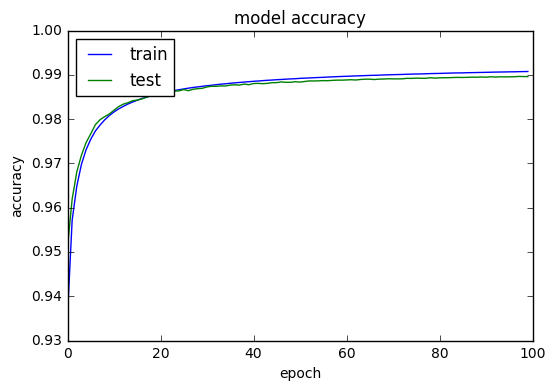

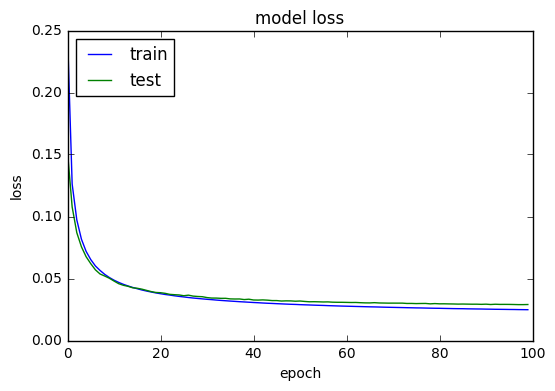

In [16]:
if KINECT == 0:
    # list all data in history
    print(history_.keys())
    # summarize history for accuracy
    plt.plot(history_['acc'])
    plt.plot(history_['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history_['loss'])
    plt.plot(history_['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Model visualization

In [17]:
# plot_model(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [18]:
# if KINECT == 0:
score = autoencoder.evaluate(test_data, test_label, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

# score = autoencoder.evaluate(train_data, train_label, verbose=0)
# print('Train score:', score[0])
# print('Train accuracy:', score[1])

10500/10500 [==============================] - 74s    
Test score: 0.0289315678619
Test accuracy: 0.98962066941


### Visualizing results

In [98]:
# if KINECT == 0:
testing_indx = np.random.choice(n_test, 5)

5/5 [==============================] - 0s


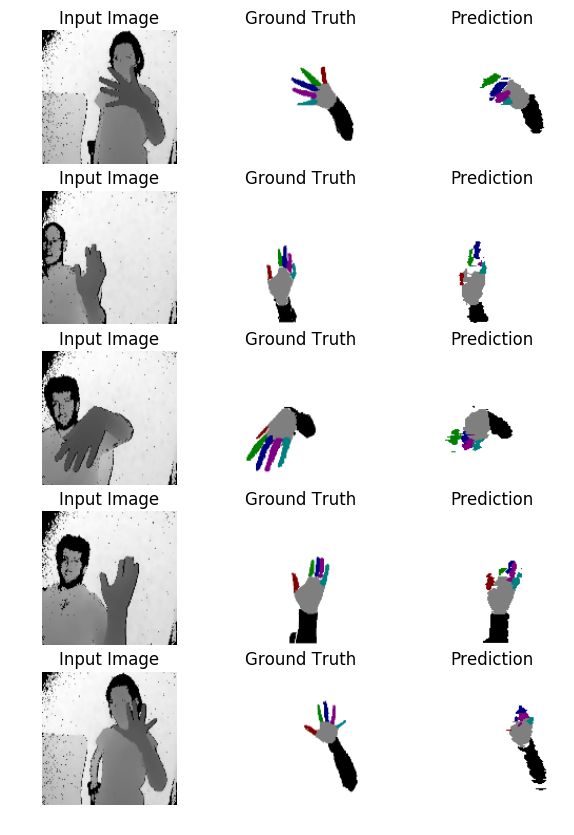

In [99]:
test_ite = test_data[testing_indx, :, :, :]
# test_ite = np.expand_dims(test_ite, axis=0)

# output = autoencoder.predict_proba(test_ite, verbose=1)
output = autoencoder.predict_classes(test_ite, verbose=1)

plot_results_2(output, testing_indx)

In [21]:
# test_ite_ = test_ite[0, :, :, 0]
# # test_ite_ = np.rot90(test_ite_, -1)

# # cv2.imshow('depth', test_ite_)

# frame8bit = test_ite_
# # frame8bit = np.flip(frame8bit, 0)
# # frame8bit = np.rot90(frame8bit, -1)
# print(frame8bit)

# cv2.imshow('original image', frame8bit)
# print(frame8bit.shape)

# frame8bit_for_autoencoder = np.resize(frame8bit, (1, 128, 128, 1))

# output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
# output = output.reshape((output.shape[0], img_h, img_w, n_labels))

# frame8bit = resize(frame8bit[:, :], (img_h, img_w))

# rgb = np.zeros((img_h, 2*img_w, 3))
# labeled = np.argmax(output[0], axis=-1)

# rgb[:, :img_w, 0] = frame8bit
# rgb[:, :img_w, 1] = frame8bit
# rgb[:, :img_w, 2] = frame8bit

# rgb[:, img_w:, 0] = labeled

# #             rgb = cv2.resize(rgb, (2*256, 213))
# # #             rgb = cv2.resize(rgb, (512, 424))

# pred_time = time.time() - start_time
# print('FPS: ' + str(int(1.0/pred_time)))

# cv2.imshow('hand segmentation', rgb)


# k = cv2.waitKey(0) & 0xff
# if k == 27:     # Esc
#     cv2.destroyAllWindows()

In [22]:
# cv2.destroyAllWindows()

# Realtime visualization

In [23]:
# if KINECT == 0:
#     # test_data, test_label = prep_data('test')

#     if AD_TEST_ONLY == 0:
#         df = pd.read_csv(path + TEST_CSV)
#     else:
#         df = pd.read_csv(path + AD_TEST_CSV)

#     n_test_imgs = 1
#     n_type_outputs = 3

#     for i, item in df.iterrows():
#         clear_output(wait=True)

#         # Call trained model
#         test_ite = test_data[i, :, :, :]
#         test_ite = np.expand_dims(test_ite, axis=0)
#         print(test_ite.shape)
#         start_time = time.time()
#         output = autoencoder.predict_proba(test_ite, verbose=0)
#         pred_time = time.time() - start_time
#         output = output.reshape((output.shape[0], img_h, img_w, n_labels))

#         # Load input image
#         im = resize(imread(path + item[0]), (img_h, img_w))

#         # Load ground truth
#         gt = np.ceil(resize(~(imread(path + item[1])[:, :, 0]), (img_h, img_w))).astype(int)

#     #     rgb = np.empty((img_h, img_w, 3))
#         rgb = np.empty((img_h, 3*img_w, 3))
#         labeled = np.argmax(output[0], axis=-1)
#         img = resize(imread(path + item[0]), (img_h, img_w))
#         rgb[:, :img_w, 0] = img
#         rgb[:, :img_w, 1] = img
#         rgb[:, :img_w, 2] = img

#         rgb[:, img_w:2*img_w, 0] = img
#         rgb[:, img_w:2*img_w, 1] = img
#         rgb[:, img_w:2*img_w, 2] = img + gt

#         rgb[:, 2*img_w:, 0] = img
#         rgb[:, 2*img_w:, 1] = img + labeled
#         rgb[:, 2*img_w:, 2] = img

#         rgb = cv2.resize(rgb, (3*256, 213))

#         cv2.imshow('hand segmentation', rgb)
#         print('FPS: ' + str(int(1.0/pred_time)))

#         k = cv2.waitKey(30) & 0xff
#         if k == 27:     # Esc
#             cv2.destroyAllWindows()
#             break

# Kinect Hand Segmentation

In [24]:
# cv2.destroyAllWindows()
# kinect.close()

In [25]:
# if KINECT == 1:
#     kinect = PyKinectRuntime.PyKinectRuntime(PyKinectV2.FrameSourceTypes_Depth)
    
#     for dir_path, dir_names, file_names in os.walk('E:/fingerpaint_dataset_segnet/data/depth/combinedSubjectA_depth'):
#         for file_name in [f for f in file_names if f.endswith('.png')]:
#             depth_img = os.path.join(dir_path, file_name).replace("\\","/")
            
# #     while True:
# #         if kinect.has_new_depth_frame():
#             clear_output(wait=True)
            
#             start_time = time.time()
            
#             # Getting frames
#             frame = kinect.get_last_color_frame()
# #             frame = kinect.get_last_depth_frame()

#             # Displaying frames
#             # if frame is None:  # some usb hub do not provide the depth image. it works with Kinect studio though
#             #     return
            
# #             print(frame)
#             f8=np.uint8(frame.clip(1,1000)/16.)
# #             f8=np.uint8(frame.clip(1,4000)/16.)
# #             frame8bit_ = frame8bit
# #             frame8bit = np.dstack((frame8bit_, frame8bit_, frame8bit_))
#             frame8bit = np.dstack((f8,f8,f8))
#             frame8bit = np.reshape(frame8bit, (kinect.depth_frame_desc.Height, kinect.depth_frame_desc.Width, 3))
#             frame8bit = frame8bit[:, :, 0]
            
#             frame8bit = imread(depth_img)
            
#             frame8bit = resize(frame8bit, (img_h, img_w))
            
#             frame8bit_for_autoencoder = np.rot90(frame8bit)
#             frame8bit_for_autoencoder = np.flip(frame8bit_for_autoencoder, 0)
            
#             frame8bit_for_autoencoder = np.resize(frame8bit_for_autoencoder, (1, 128, 128, 1))
            
#             output = autoencoder.predict_proba(frame8bit_for_autoencoder, verbose=0)
#             output = output.reshape((output.shape[0], img_h, img_w, n_labels))

#             rgb = np.zeros((img_h, 2*img_w, 3))
#             labeled = np.argmax(output[0], axis=-1)
            
#             rgb[:, :img_w, 0] = frame8bit
#             rgb[:, :img_w, 1] = frame8bit
#             rgb[:, :img_w, 2] = frame8bit
            
#             rgb[:, img_w:, 0] = frame8bit
#             rgb[:, img_w:, 1] = frame8bit + labeled
#             rgb[:, img_w:, 2] = frame8bit

#             rgb = cv2.resize(rgb, (2*256, 213))
# # #             rgb = cv2.resize(rgb, (512, 424))
            
#             pred_time = time.time() - start_time
#             print('FPS: ' + str(int(1.0/pred_time)))
            
#             cv2.imshow('hand segmentation', rgb)

#             k = cv2.waitKey(30) & 0xff
#             if k == 27:     # Esc
#                 # Releasing frames
#                 frame = None
#                 cv2.destroyAllWindows()
#                 kinect.close()
#                 break